In [1]:
from models.det_allhist_glm import Det_AllHist_GLM

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub5_C_syn_e.npy"
C_syn_i_file = "handsub5_C_syn_i.npy"
C_den_file = "handsub5_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

#####
V[V < 0.3] = 0

In [3]:
T_train = 8 * 1000 * 50
T_test = 1 * 1000 * 50
T_no = 750
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 1000
iter_no = 2500
epoch_no = 50
layer_no = 3

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)


batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    #part_idx = np.arange(T_train - batch_size)
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = Det_AllHist_GLM(C_den, C_syn_e, C_syn_i, T_no, device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

132


In [6]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred, Z_pred, P_pred, out_filters = model(batch_E_neural, batch_I_neural)
        
    loss = torch.mean((V_pred - batch_V)**2)
    #loss = torch.var(V_pred - batch_V)
    
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_V_pred, test_Z_pred, test_P_pred, test_out_filters = model(test_E_neural, test_I_neural) 
         
        test_mse = torch.mean((test_V_pred - V_test)**2).item()
        test_var = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        
        print(i, np.round(test_var, 6),
              np.round(test_mse, 6),
              torch.sum(test_Z_pred).item(),
             model.W_out.item(),
             model.Tau_out.item())


<ipython-input-6-9abb0e8d5fb6>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 -45.66177 1.187099 2767.0 0.4324394166469574 -1.7435411214828491
199 -14.986318 0.383759 1483.0 0.41387927532196045 -1.731252670288086
299 -3.840201 0.106991 645.0 0.40495285391807556 -1.7253692150115967
399 -1.965167 0.064167 427.0 0.4010617434978485 -1.7229987382888794
499 -1.326001 0.049981 355.0 0.39892786741256714 -1.721784234046936
599 -1.081127 0.044578 316.0 0.39737871289253235 -1.7209912538528442
699 -0.542089 0.033038 221.0 0.39465686678886414 -1.719469428062439
799 -0.529945 0.032785 217.0 0.3925684690475464 -1.7182804346084595
899 -0.416837 0.030389 207.0 0.3914514482021332 -1.7176774740219116
999 -0.412685 0.030304 206.0 0.38975387811660767 -1.716835379600525
1099 -0.375775 0.029519 200.0 0.38794469833374023 -1.7159268856048584
1199 -0.306858 0.028069 193.0 0.3855023980140686 -1.7146756649017334
1299 -0.355954 0.029104 196.0 0.3842153251171112 -1.7140765190124512
1399 -0.32816 0.02853 193.0 0.3821922838687897 -1.713079571723938
1499 -0.281599 0.027531 190.0 0.3797291815

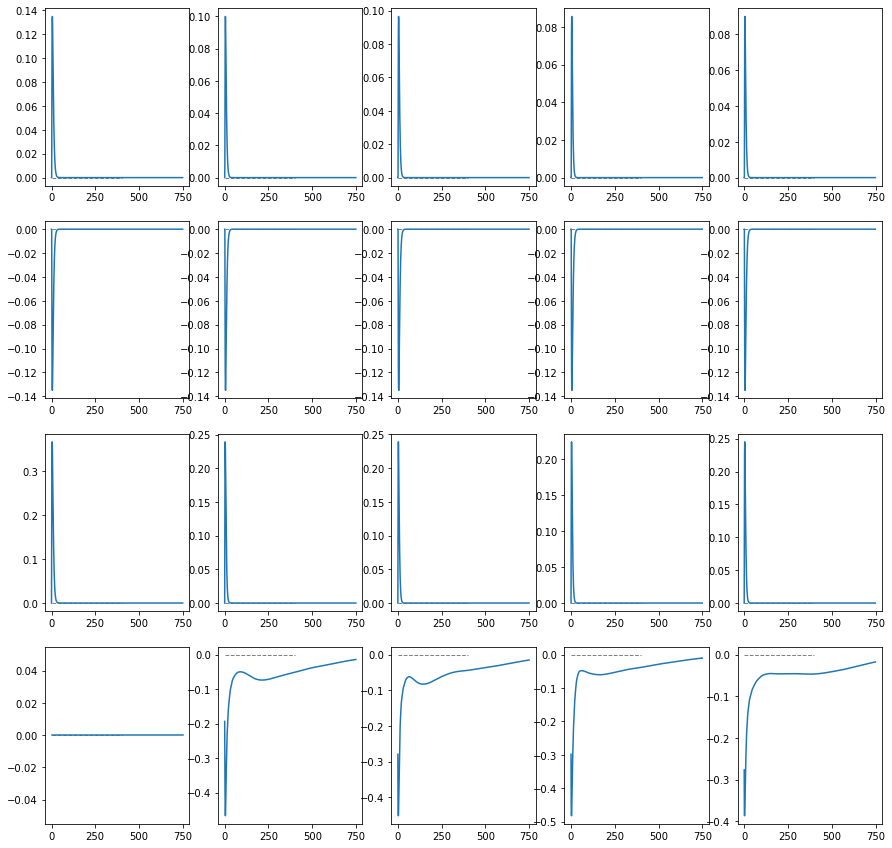

In [7]:
sub_no = 5
fig, axs = plt.subplots(nrows=4, ncols=sub_no, figsize=(15,15))
for row in range(4):
    for col in range(sub_no):
        axs[row,col].plot(test_out_filters[row*sub_no+col].cpu().detach().numpy()[:750])
        axs[row,col].hlines(y=0,xmin=0,xmax=400, color="gray",linewidth=1,linestyle="--")

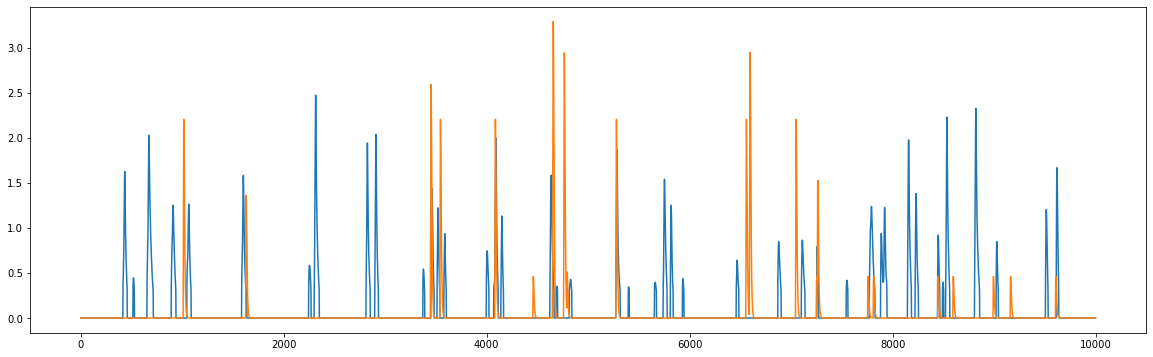

In [8]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])


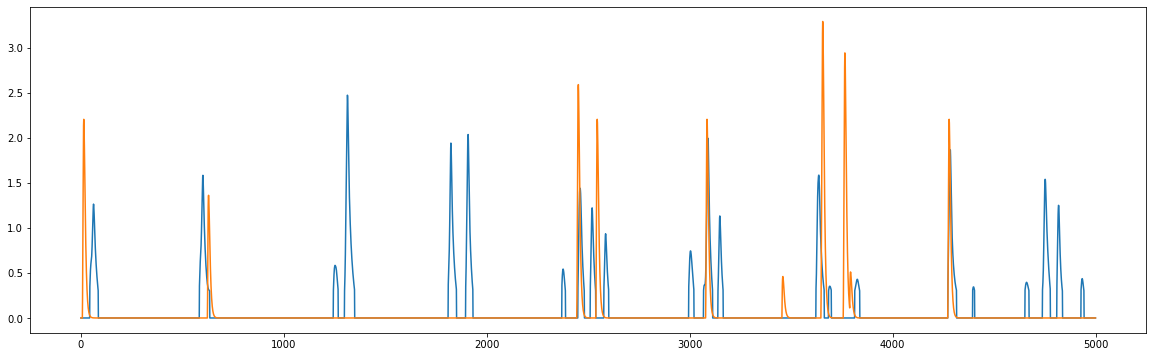

In [9]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][1000:6000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][1000:6000])


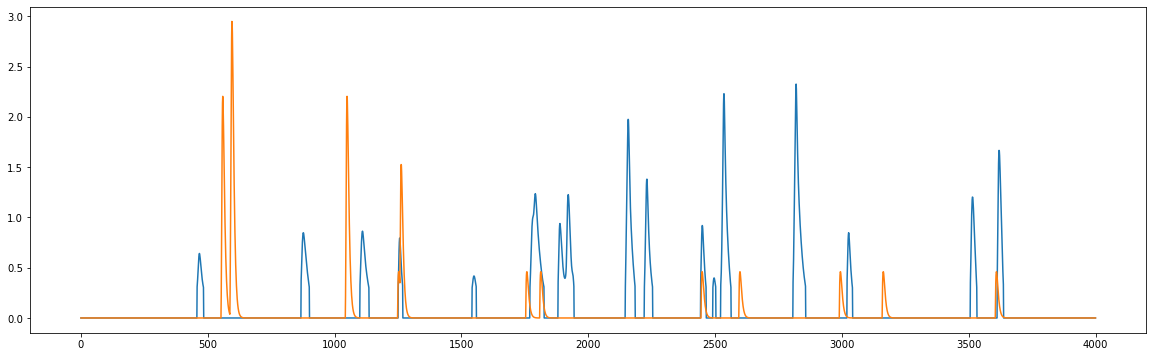

In [10]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][6000:10000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][6000:10000])


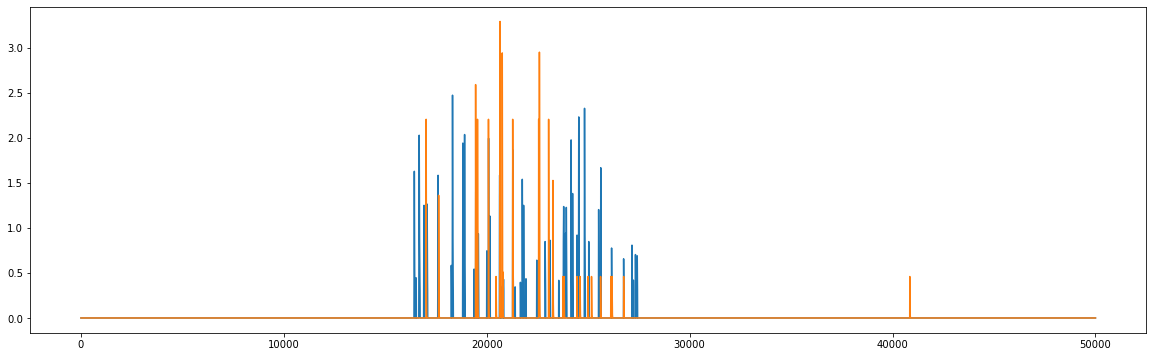

In [11]:
plt.figure(figsize=(20,6))
plt.plot(V_test.cpu().detach().numpy()[:])
plt.plot(test_V_pred.cpu().detach().numpy()[:])


In [12]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

Tau_syn tensor([[-1.0000, -1.0000],
        [-0.8158, -1.0000],
        [-0.8001, -1.0000],
        [-0.6610, -1.0000],
        [-0.7455, -1.0000]], device='cuda:0')
Delta_syn tensor([[ 0.0000,  0.0000],
        [-0.1065,  0.0000],
        [ 0.0692,  0.0000],
        [ 0.0014,  0.0000],
        [ 0.0045,  0.0000]], device='cuda:0')
W_syn tensor([[-1.0000, -1.0000],
        [-1.3015, -1.0000],
        [-1.3339, -1.0000],
        [-1.4588, -1.0000],
        [-1.4080, -1.0000]], device='cuda:0')
Tau_spk tensor([-1.0000, -0.6937, -0.7196, -0.6605, -0.7333], device='cuda:0')
W_spk tensor([ 0.0000, -0.4297, -0.4317, -0.4979, -0.4057], device='cuda:0')
W_hist tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [-0.1223, -0.1422, -0.1726, -0.2087, -0.2491, -0.2252, -0.1587, -0.1078,
         -0.0737, -0.0471, -0.0314, -0.0250, -0.0220, -0.0353, -0.0428, -0.02